In [1]:
import warnings
warnings.filterwarnings('ignore') # 忽略警告
import pandas as pd
from pandas import IndexSlice as idx
pd.set_option('display.max_columns', None)  # 当列太多时不换行
df = pd.read_parquet('cb_data.pq') # 导入转债数据
index = pd.read_parquet('index.pq') # 导入指数数据

---
### 下方可修改


In [2]:
# 基础设置
start_date = '20210101' # 开始日期
end_date = '20230918' # 结束日期
hold_num = 5 # 持有数量
c_rate =  1 / 1000 # 买卖一次花费的总佣金和滑点（双边）
benchmark = 'index_jsl' # 选择基准，集思录等权:index_jsl, 沪深300:index_300, 中证1000:index_1000, 国证2000:index_2000

In [4]:
# 排除设置
df = df[(df.index.get_level_values('trade_date') >= start_date) & (df.index.get_level_values('trade_date') <= end_date)] # 选择时间范围内数据
df['filter'] = False # 初始化过滤器
df.loc[df.is_call.isin(['已公告强赎', '公告到期赎回','公告实施强赎', '公告提示强赎', '已满足强赎条件']), 'filter'] = True # 排除赎回状态
df.loc[df.list_days <= 3, 'filter'] = True # 排除新债

df.loc[df.remain_size > 2, 'filter'] = True # 排除剩余规模大于2个亿的标的

# df['close_pct'] = df.groupby('trade_date')['close'].rank(pct=True) # 将收盘从小到大百分比排列
df.loc[df.close > 140, 'filter'] = True # 排除收盘价高于140的标的
df.loc[df.close < 120, 'filter'] = True # 排除收盘价低于120的标的

In [5]:
# 计算多因子得分 和 排名(score总分越大越好， rank总排名越小越好)
df['prem_score'] = df.loc[df['filter'] == False, 'pct_chg_5'].groupby('trade_date').rank(ascending=False) # 3日跌幅因子得分
#df['close_score'] = df.loc[df['filter'] == False, 'pct_chg_5'].groupby('trade_date').rank(ascending=False) # 价格因子得分

df['score'] = df['prem_score'] #计算总分
df['rank'] = df.groupby('trade_date')['score'].rank('first', ascending=False) # 按总分从高到低计算排名

### 上方可修改
---

In [6]:
# 计算每日信号 采样信号 持仓状态
code_group = df.groupby('code')
df['time_return'] = code_group.pct_chg.shift(-1) # 计算标的每日回报
df.loc[(df['rank'] <= hold_num), 'signal'] = 1 # 标记信号
df.dropna(subset=['signal'], inplace=True) # 删除没有标记的行
df.sort_values(by='trade_date', inplace=True) # 按日期排序

In [7]:
# 计算组合回报
res = pd.DataFrame()
res['time_return'] = df.groupby('trade_date')['time_return'].mean() # 按等权计算组合回报
# 计算手续费
pos_df = df['signal'].unstack('code')
pos_df.fillna(0, inplace=True)
res['cost'] = pos_df.diff().abs().sum(axis=1) * c_rate / (pos_df.shift().sum(axis=1) + pos_df.sum(axis=1))
res.iloc[0, 1] = 0.5 * c_rate# 修正首行手续费
res['time_return'] = (res['time_return'] + 1) * (1 - res['cost']) - 1# 扣除手续费及佣金后的回报

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2021-01-04  2021-01-04
End Period                 2023-09-18  2023-09-18
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          143.16%     29.09%
CAGR﹪                     38.9%       9.9%

Sharpe                     1.85        0.88
Prob. Sharpe Ratio         99.86%      92.02%
Smart Sharpe               1.68        0.8
Sortino                    2.93        1.22
Smart Sortino              2.65        1.1
Sortino/√2                 2.07        0.86
Smart Sortino/√2           1.88        0.78
Omega                      1.42        1.42

Max Drawdown               -20.96%     -14.82%
Longest DD Days            188         396
Volatility (ann.)          19.38%      11.84%
R^2                        0.05        0.05
Information Ratio          0.08        0.08
Calmar                     1.86        0.6

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-01-06,2021-02-05,2021-07-13,188,-20.963260,-20.204706
2,2022-07-28,2022-08-31,2023-01-20,176,-9.843807,-8.017064
3,2023-04-07,2023-05-12,2023-06-29,83,-7.699184,-7.349776
4,2022-04-20,2022-04-22,2022-04-29,9,-6.501862,-6.195490
5,2022-01-12,2022-02-14,2022-02-28,47,-5.898077,-5.426263


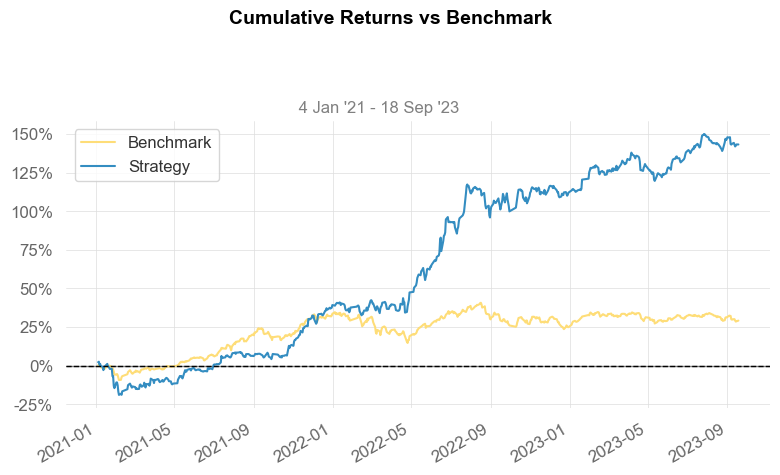

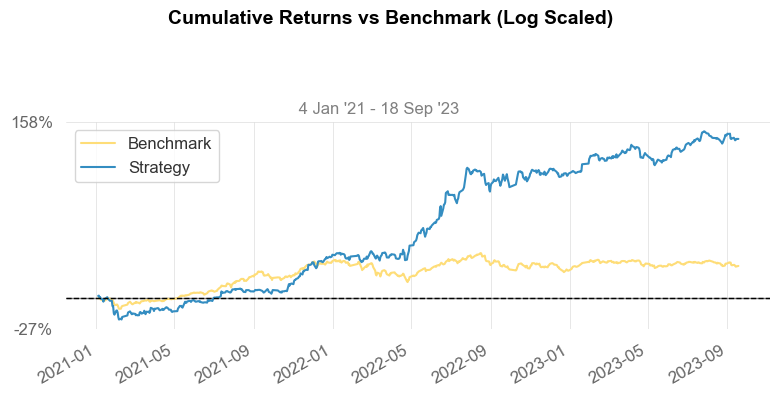

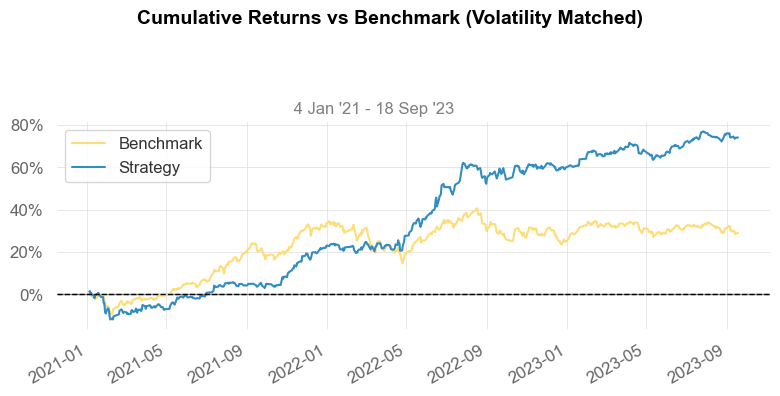

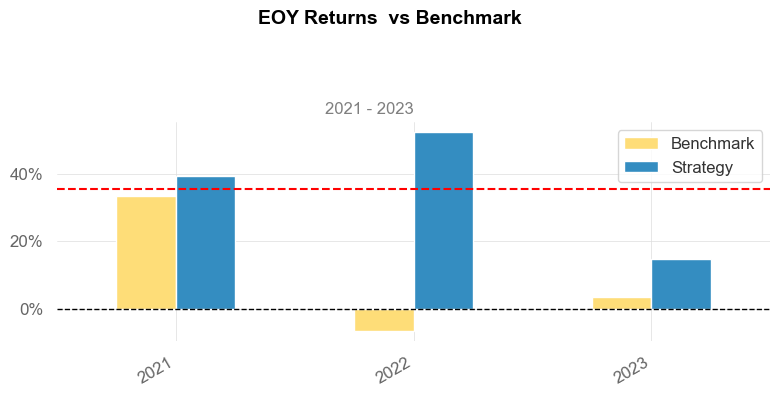

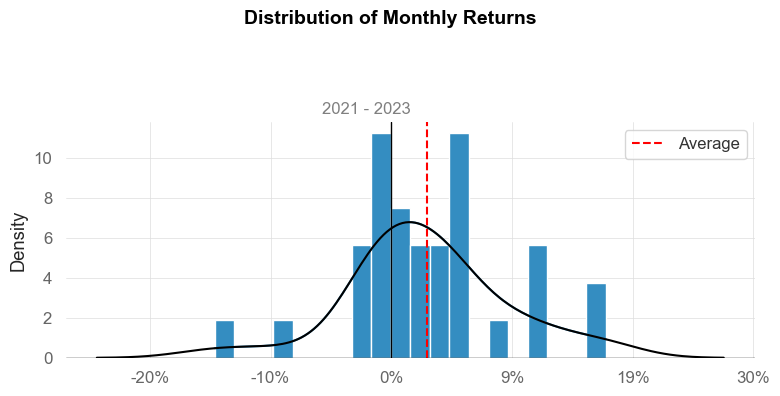

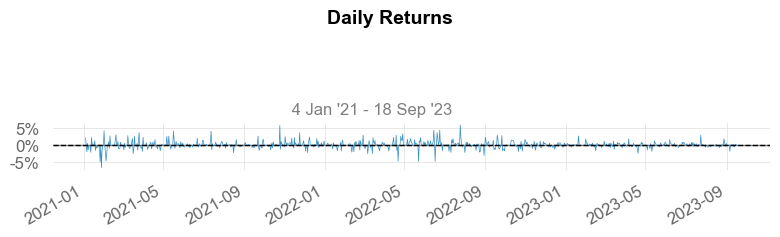

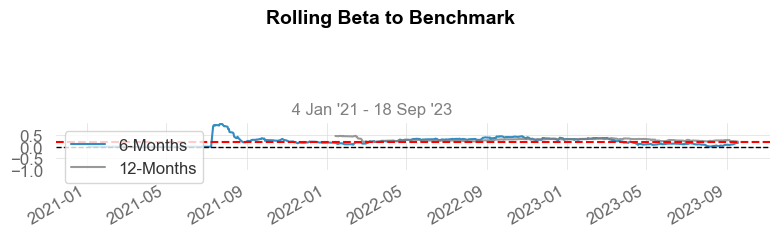

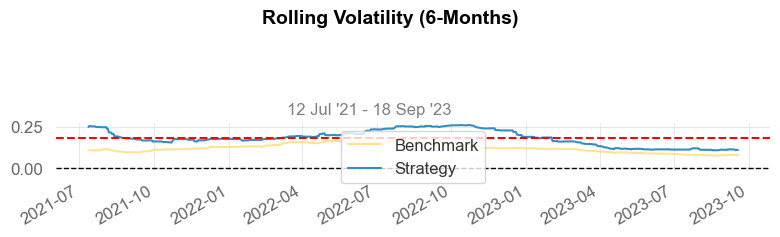

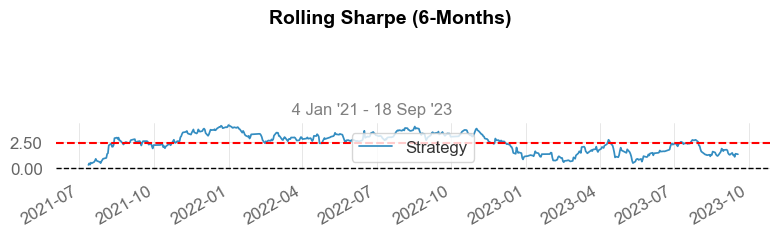

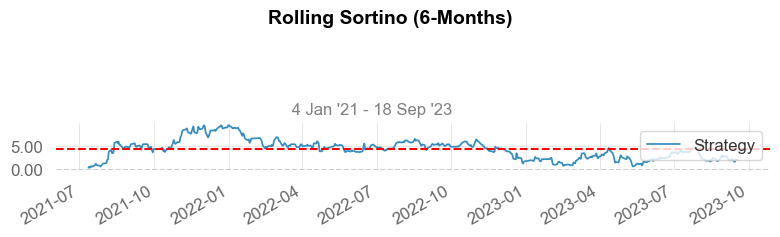

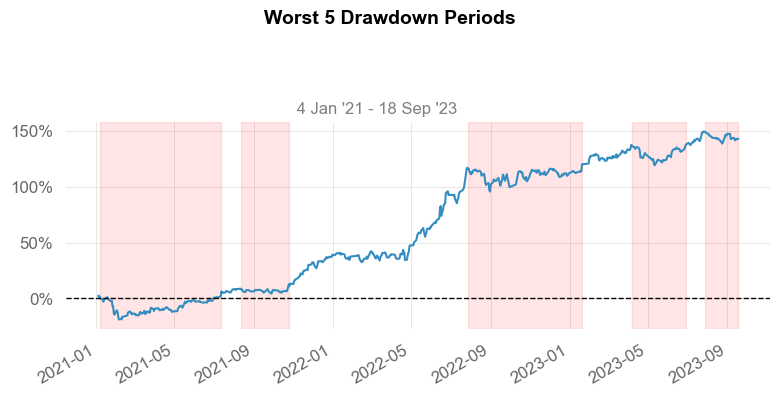

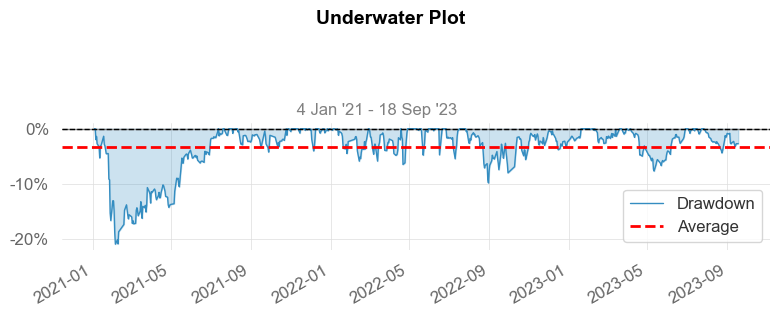

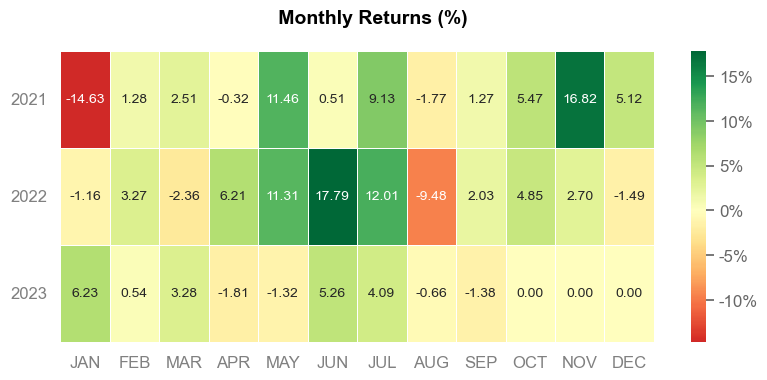

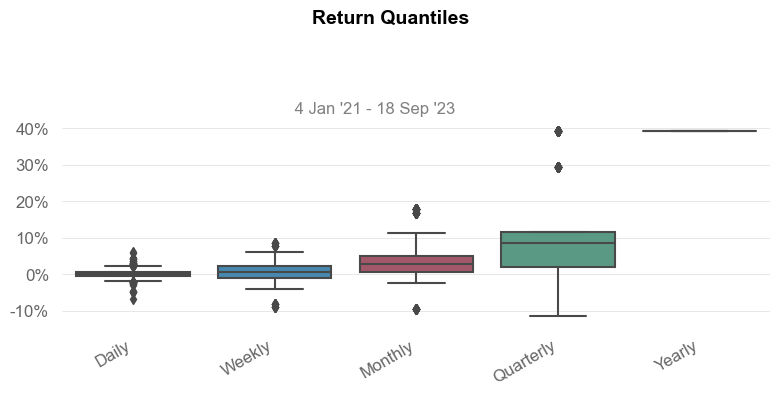

In [9]:
# 用quantstats生成评价报告s
import quantstats as qs
qs.reports.full(res.time_return, benchmark=index[benchmark])

In [95]:
# 查看某个交易日选出的标的
_df = df.reset_index()
_df[_df.trade_date=='2020-01-09'].sort_values(by='rank') # 查看某日

,code,trade_date,name,pre_close,open,high,low,close,pct_chg,vol,amount,volatility,code_stk,name_stk,pre_close_stk,open_stk,high_stk,low_stk,close_stk,pct_chg_stk,vol_stk,amount_stk,pe_ttm,pb,ps_ttm,total_share,float_share,total_mv,circ_mv,debt_to_assets,volatility_stk,pct_chg_5,pct_chg_5_stk,is_call,conv_price,conv_value,conv_prem,dblow,issue_size,remain_size,remain_cap,turnover,cap_mv_rate,list_date,list_days,conv_start_date,left_conv_start_days,conv_end_date,left_years,ytm,pure_value,bond_prem,option_value,theory_value,theory_bias,rating,yy_rating,orgform,area,industry_1,industry_2,industry_3,popularity_ranking,theory_conv_prem,mod_conv_prem,filter,prem_score,score,rank,time_return,signal


In [9]:
!pip list

Package                       Version
----------------------------- ---------------
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
black                         22.6.0
bleac